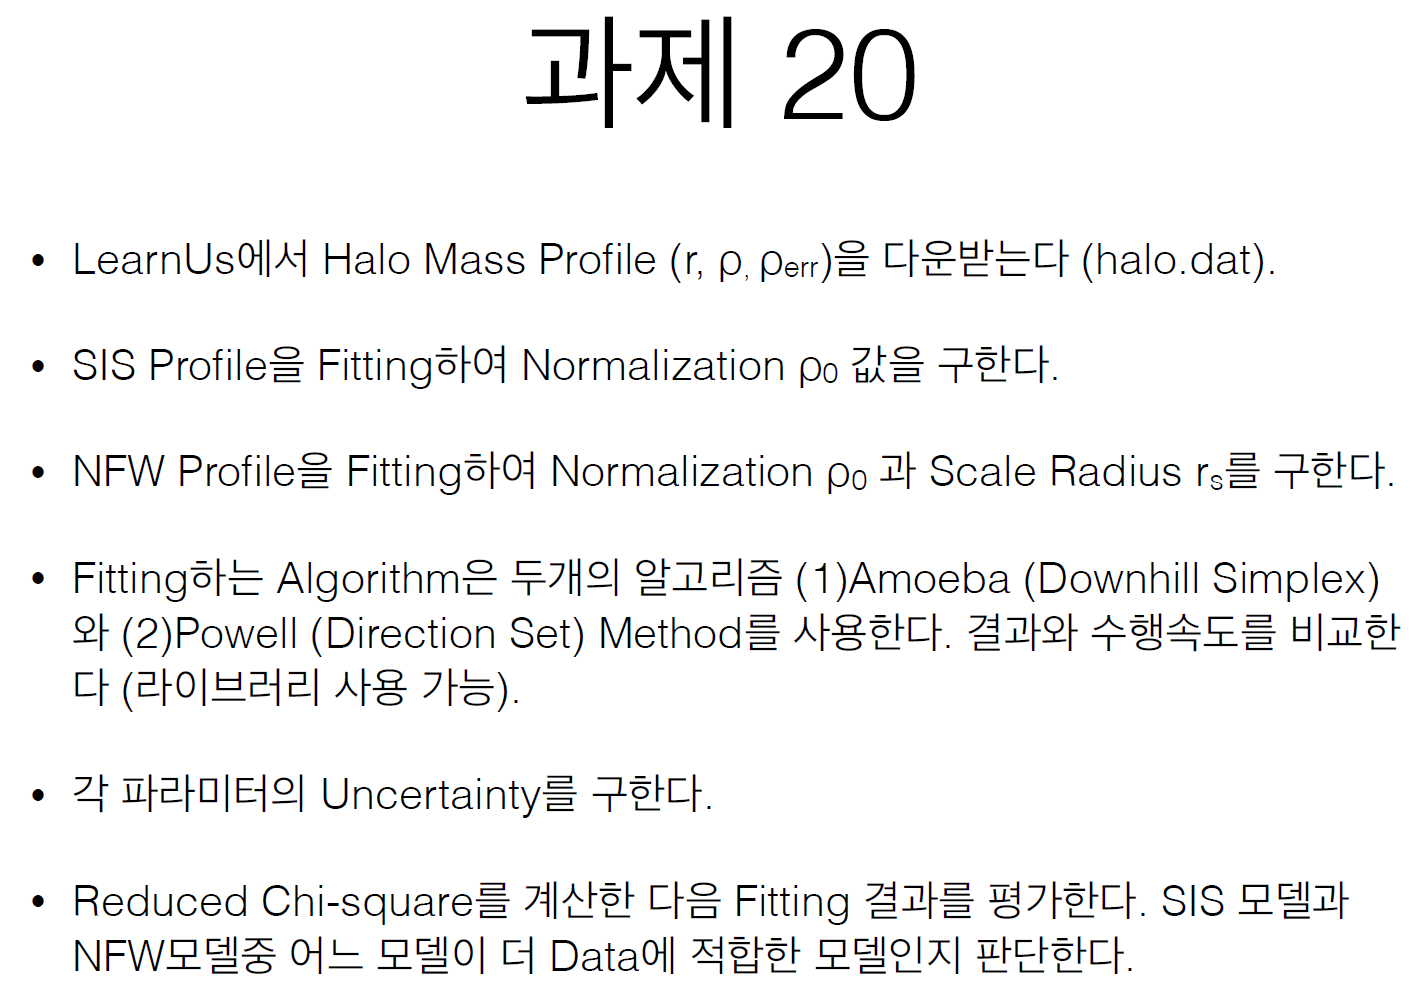

In [158]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import time

Text(0, 0.5, '$\\rho$')

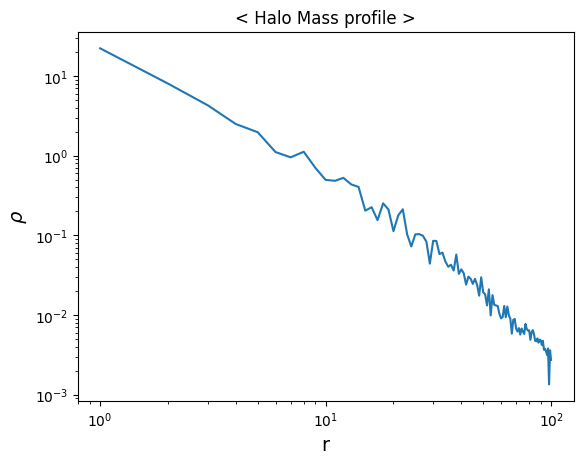

In [159]:
halo = pd.read_csv('halo.dat', names=['r', 'rho', 'rho_err'], sep=r'\s+')
plt.title('< Halo Mass profile >')
plt.loglog(halo['r'], halo['rho'])
plt.xlabel('r', fontsize=14); plt.ylabel(r'$\rho$', fontsize=14)

In [160]:
def chi2(params, r, rho, rho_err, function):
    chi_value = function(params, r, rho, rho_err)
    return np.sum(((chi_value - rho)/rho_err)**2)

def SIS(params, r, rho, rho_err):
    rho0 = params
    return rho0 / r**2

def NFW(params, r, rho, rho_err):
    rho0, rs = params
    return rho0 / (r/rs * (1 + r/rs)**2)

In [161]:
st = time.time()
result_sis_ds = opt.minimize(
    chi2,
    x0=[0.1],
    args=(halo['r'], halo['rho'], halo['rho_err'], SIS),
    method='Nelder-Mead'
);et = time.time(); print("Time for sis with downhill(SIS):".ljust(35)+ str(et - st)+"s")

st = time.time()
result_sis_po = opt.minimize(
    chi2,
    x0=[0.1],
    args=(halo['r'], halo['rho'], halo['rho_err'], SIS),
    method='Powell'
);et = time.time(); print(f"Time for sis with Powell(SIS):".ljust(35)+ str(et - st)+'s')

st = time.time()
result_nfw_ds = opt.minimize(
    chi2,
    x0=[0.1, 0.1],
    args=(halo['r'], halo['rho'], halo['rho_err'], NFW),
    method='Nelder-Mead'
);et = time.time(); print(f"Time for sis with downhill(NFW):".ljust(35)+ str(et - st)+'s')

st = time.time()
result_nfw_po = opt.minimize(
    chi2,
    x0=[0.1, 0.1],
    args=(halo['r'], halo['rho'], halo['rho_err'], NFW),
    method='Powell'
);et = time.time(); print(f"Time for sis with Powell(NFW):".ljust(35)+ str(et - st)+'s')

Time for sis with downhill(SIS):   0.011932134628295898s
Time for sis with Powell(SIS):     0.00831913948059082s
Time for sis with downhill(NFW):   0.045564889907836914s
Time for sis with Powell(NFW):     0.20072507858276367s


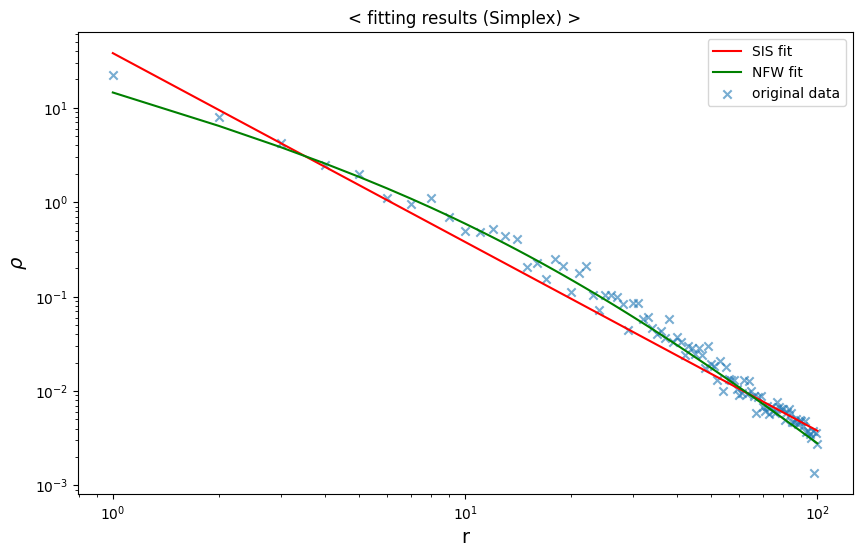

In [162]:
plt.figure(figsize=(10, 6))
plt.title('< fitting results (Simplex) >')
plt.xscale('log'); plt.yscale('log')
plt.plot(halo['r'], SIS(result_sis_ds.x, halo['r'], halo['rho'], halo['rho_err']), label='SIS fit', color='red')
plt.plot(halo['r'], NFW(result_nfw_ds.x, halo['r'], halo['rho'], halo['rho_err']), label='NFW fit', color='green')
plt.scatter(halo['r'], halo['rho'], label='original data', marker='x', alpha=0.6)
plt.xlabel('r', fontsize=14); plt.ylabel(r'$\rho$', fontsize=14)
plt.legend()

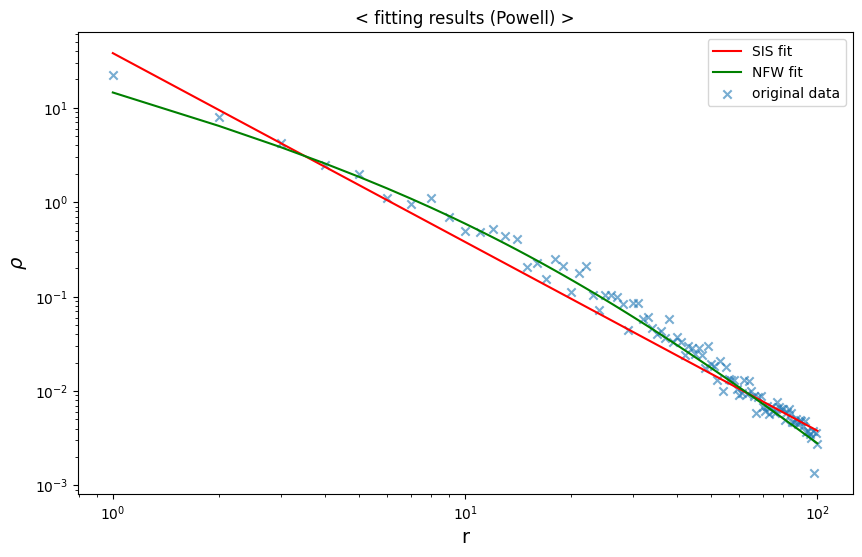

In [163]:
plt.figure(figsize=(10, 6))
plt.title('< fitting results (Powell) >')
plt.xscale('log'); plt.yscale('log')
plt.plot(halo['r'], SIS(result_sis_po.x, halo['r'], halo['rho'], halo['rho_err']), label='SIS fit', color='red')
plt.plot(halo['r'], NFW(result_nfw_po.x, halo['r'], halo['rho'], halo['rho_err']), label='NFW fit', color='green')
plt.scatter(halo['r'], halo['rho'], label='original data', marker='x', alpha=0.6)
plt.xlabel('r', fontsize=14); plt.ylabel(r'$\rho$', fontsize=14)
plt.legend()

In [164]:
def uncert_1d(func, x, args, h=1e-5):
    result = (func(x + h, *args) - 2 * func(x, *args) + func(x - h, *args)) / (h**2)
    return np.sqrt(result**-1)

def gradient(func, x, args, h=1e-4):
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp = x[idx]
        x[idx] = tmp + h
        f_x_plux_h = func(x, *args)
        
        x[idx] = tmp
        fx = func(x, *args)
        
        grad[idx] = (f_x_plux_h - fx) / h
        x[idx] = tmp
    return grad

def hessian(func, x, args, h=1e-4):
    hess = np.zeros_like((x, x))
    x_n = x.copy()
    
    for idx in range(x.size):
        x_n[idx] = x[idx] + h
        df_x_plux_h = gradient(func, x_n, args)
        
        df_x = gradient(func, x, args)
        
        hess[:, idx] = (df_x_plux_h - df_x) / h
        x_n = x.copy()
    return hess

def uncert_2d(func, x, args, h=1e-4):
    hess = hessian(func, x, args, h)
    return np.sqrt(np.diag(np.linalg.inv(hess)))

In [165]:
uncert_sis_ds = uncert_1d(chi2, result_sis_ds.x, (halo['r'], halo['rho'], halo['rho_err'], SIS))
uncert_nfw_ds = uncert_2d(chi2, result_nfw_ds.x, (halo['r'], halo['rho'], halo['rho_err'], NFW))
uncert_sis_po = uncert_1d(chi2, result_sis_po.x, (halo['r'], halo['rho'], halo['rho_err'], SIS))
uncert_nfw_po = uncert_2d(chi2, result_nfw_po.x, (halo['r'], halo['rho'], halo['rho_err'], NFW))
print(f"Uncertainty of SIS (downhill): {uncert_sis_ds}")
print(f"Uncertainty of NFW (downhill): {uncert_nfw_ds}\n")
print(f"Uncertainty of SIS (Powell): {uncert_sis_po}")
print(f"Uncertainty of NFW (Powell): {uncert_nfw_po}")

Uncertainty of SIS (downhill): 0.6037626536889779
Uncertainty of NFW (downhill): [0.11549162 0.64219482]

Uncertainty of SIS (Powell): 0.6036375863331692
Uncertainty of NFW (Powell): [0.11559002 0.64264461]


In [167]:
def reduced_chi2(func, params, args):
    model = func(params, *args)
    chi = np.sum(((model - args[1])/args[2])**2)
    freedom = len(args[0]) - len(params)
    return chi / freedom

In [169]:
rchi_sis_ds = reduced_chi2(SIS, result_sis_ds.x, (halo['r'], halo['rho'], halo['rho_err']))
rchi_nfw_ds = reduced_chi2(NFW, result_nfw_ds.x, (halo['r'], halo['rho'], halo['rho_err']))
rchi_sis_po = reduced_chi2(SIS, result_sis_po.x, (halo['r'], halo['rho'], halo['rho_err']))
rchi_nfw_po = reduced_chi2(NFW, result_nfw_po.x, (halo['r'], halo['rho'], halo['rho_err']))

print(f"Reduced Chi-Squared >> RCS")
print(f"RCS SIS (downhill): {rchi_sis_ds}")
print(f"RCS NFW (downhill): {rchi_nfw_ds}\n")
print(f"RCS SIS (Powell): {rchi_sis_po}")
print(f"RCS NFW (Powell): {rchi_nfw_po}")

Reduced Chi-Squared >> RCS
RCS SIS (downhill): 2.6039428134581475
RCS NFW (downhill): 1.2234822043042866

RCS SIS (Powell): 2.6039428134557725
RCS NFW (Powell): 1.2234822189633887
